In [1]:
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
filename = 'train.csv'
filename_q = 'questions.csv'

In [3]:
df = pd.read_csv(filename)

In [4]:
df.head()

row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692                0                  1   
1       1      56943      115        5716                0                  2   
2       2     118363      115         128                0                  0   
3       3     131167      115        7860                0                  3   
4       4     137965      115        7922                0                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

  prior_question_had_explanation  
0                            NaN  
1                          False  
2                          False  
3                          False  
4                          False

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


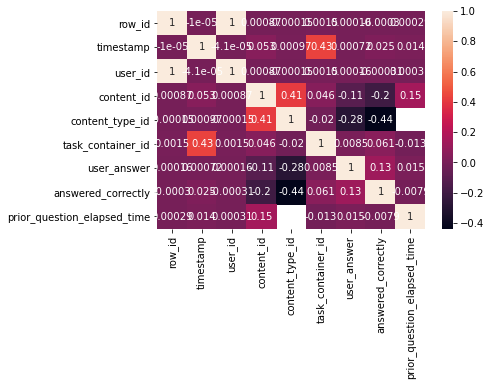

In [6]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [7]:
# Можно отметить content_type_id  по их значению корреляции с переменной user_answer
corrMatrix['answered_correctly'] 

row_id                        -0.000303
timestamp                      0.025452
user_id                       -0.000307
content_id                    -0.196960
content_type_id               -0.436912
task_container_id              0.061129
user_answer                    0.126471
answered_correctly             1.000000
prior_question_elapsed_time   -0.007900
Name: answered_correctly, dtype: float64

#### 

In [8]:
dq = pd.read_csv(filename_q)
dq.head(2)

question_id  bundle_id  correct_answer  part           tags
0            0          0               0     1  51 131 162 38
1            1          1               1     1      131 36 81

In [9]:
dq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


#### Feature eng.

In [10]:
df = df.dropna()

In [11]:
# Создаем новые фичи - количество отвеченных вопросов и правильное количество как среднее.
user_correct = df.groupby('user_id')['answered_correctly'].agg(user_sum = 'sum', 
                user_mean = 'mean').reset_index()
user_correct

user_id  user_sum  user_mean
0              115        31   0.688889
1              124         6   0.206897
2             2746        11   0.611111
3             5382        83   0.669355
4             8623        69   0.638889
...            ...       ...        ...
393564  2147470770       172   0.764444
393565  2147470777       520   0.692410
393566  2147481750        38   0.775510
393567  2147482216       177   0.645985
393568  2147482888        14   0.538462

[393569 rows x 3 columns]

In [12]:
# максимальное время отклика каждого юзера
user_time_total =  df.groupby('user_id')['timestamp'].agg(user_time_total = 'max')
user_time_total

user_time_total
user_id                    
115               668090043
124                  571323
2746                 835457
5382             2101551456
8623              862338736
...                     ...
2147470770       2832089444
2147470777      13332685203
2147481750         55954768
2147482216       1470594073
2147482888        428692118

[393569 rows x 1 columns]

In [13]:
# соединяем в один датафрэйм
user_df = user_correct.merge(user_time_total, on = 'user_id')
user_df

user_id  user_sum  user_mean  user_time_total
0              115        31   0.688889        668090043
1              124         6   0.206897           571323
2             2746        11   0.611111           835457
3             5382        83   0.669355       2101551456
4             8623        69   0.638889        862338736
...            ...       ...        ...              ...
393564  2147470770       172   0.764444       2832089444
393565  2147470777       520   0.692410      13332685203
393566  2147481750        38   0.775510         55954768
393567  2147482216       177   0.645985       1470594073
393568  2147482888        14   0.538462        428692118

[393569 rows x 4 columns]

In [14]:
# оставляем нужные фичи
df = df[['user_id', 'content_id', 'answered_correctly','prior_question_elapsed_time', 'prior_question_had_explanation']]

In [15]:
# соединяем в один датафрэйм
df = df.merge(dq[['question_id', 'part']],
            left_on ='content_id', right_on = 'question_id', how = 'left')\
            .drop('question_id', axis = 1)
df

user_id  content_id  answered_correctly  \
0                115        5716                   1   
1                115         128                   1   
2                115        7860                   1   
3                115        7922                   1   
4                115         156                   1   
...              ...         ...                 ...   
98878789  2147482888        3586                   1   
98878790  2147482888        6341                   1   
98878791  2147482888        4212                   1   
98878792  2147482888        6343                   0   
98878793  2147482888        7995                   1   

          prior_question_elapsed_time prior_question_had_explanation  part  
0                             37000.0                          False     5  
1                             55000.0                          False     1  
2                             19000.0                          False     1  
3                             11000.0                          False     1  
4                              5000.0                          False     1  
...                               ...                            ...   ...  
98878789                      18000.0                           True     5  
98878790                      14000.0                           True     5  
98878791                      14000.0                           True     5  
98878792                      22000.0                           True     5  
98878793                      29000.0                           True     5  

[98878794 rows x 6 columns]

In [16]:
# получить среднее значение content_id и среднее значение part
question_mean = df.groupby('content_id')['answered_correctly']\
                .agg( question_mean = 'mean', question_sum = 'sum').reset_index()
part_mean = df.groupby('part')['answered_correctly'].agg( part_mean = 'mean').reset_index()

In [17]:
# соединяем в один датафрэйм
train_df = df.merge(question_mean,on ='content_id', how = 'left')\
            .drop('content_id', axis = 1)

train_df = train_df.merge(part_mean, on = 'part', how ='left')\
            .drop('part', axis = 1)

train_df = train_df.merge(user_df, on = 'user_id', how ='left')\
            .drop('user_id', axis = 1)

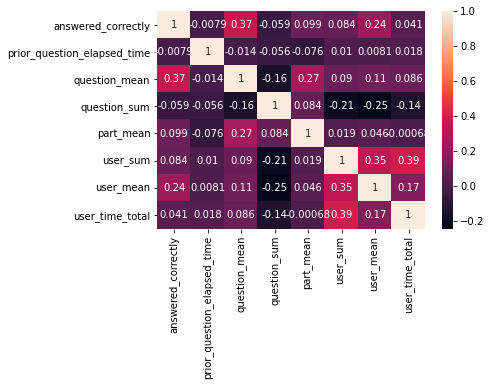

In [19]:
corrMatrix = train_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [20]:
corrMatrix['answered_correctly']

answered_correctly             1.000000
prior_question_elapsed_time   -0.007900
question_mean                  0.367167
question_sum                  -0.059375
part_mean                      0.098651
user_sum                       0.084228
user_mean                      0.240346
user_time_total                0.040811
Name: answered_correctly, dtype: float64

#### Определим важность фич

In [22]:
import sklearn.feature_selection
from sklearn.model_selection import train_test_split

In [27]:
data = train_df
X = data.drop('answered_correctly', axis=1)
y = data.answered_correctly

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state = 0)

In [30]:
def select_features(X, X_train, y_train, k):
    select = sklearn.feature_selection.SelectKBest(k=k)
    selected_features = select.fit(X_train, y_train)
    indices_selected = selected_features.get_support(indices = True)
    colnames_selected = [X.columns[i] for i in indices_selected]
    return colnames_selected

In [31]:
# например первые четыре
colnames_selected = select_features(X, X_train, y_train, 4)
colnames_selected

['prior_question_had_explanation', 'question_mean', 'part_mean', 'user_mean']